In [129]:
print("strawberry")

import torch
import numpy as np
import torch.nn.functional as F

# dataset
from twaidata.torchdatasets.in_ram_ds import MRISegmentation2DDataset, MRISegmentation3DDataset
from torch.utils.data import DataLoader, random_split, ConcatDataset

# model
from trustworthai.models.uq_models.initial_variants.HyperMapp3r_deterministic import HyperMapp3r
from trustworthai.models.uq_models.initial_variants.HyperMapp3r_DDU import HyperMapp3rDDU
from trustworthai.models.uq_models.initial_variants.HyperMapp3r_SSN import HyperMapp3rSSN
from trustworthai.models.uq_models.initial_variants.HyperMapp3r_deterministic import get_conv_func


# augmentation and pretrain processing
from trustworthai.utils.augmentation.standard_transforms import RandomFlip, GaussianBlur, GaussianNoise, \
                                                            RandomResizeCrop, RandomAffine, \
                                                            NormalizeImg, PairedCompose, LabelSelect, \
                                                            PairedCentreCrop, CropZDim
# loss function
from trustworthai.utils.losses_and_metrics.per_individual_losses import (
    log_cosh_dice_loss,
    TverskyLoss,
    FocalTverskyLoss,
    DiceLossMetric
)
from torch.nn import BCELoss, MSELoss, BCEWithLogitsLoss

# fitter
from trustworthai.utils.fitting_and_inference.fitters.basic_lightning_fitter import StandardLitModelWrapper
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
import pytorch_lightning as pl

# misc
import os
import torch
import matplotlib.pyplot as plt
import torch
from torchinfo import summary
import argparse

import torch.nn as nn
import torch
from torchmetrics import Metric

def two_class_prob(p_hat):
    p_hat = torch.nn.functional.softmax(p_hat, dim=1)
    p_hat = p_hat[:,1,:] # select class 0
    return p_hat

def individual_dice(p_hat, y_true):
    p_hat = two_class_prob(p_hat)
    s0 = p_hat.shape[0]
    p_hat = p_hat.view(s0,-1)
    y_true = y_true.view(s0,-1)
    numerator = torch.sum(2. * p_hat * y_true, dim=1) + 1.
    denominator = torch.sum(y_true + p_hat, dim=1) + 1.
    combined = 1. - (numerator/denominator)
    return combined
    
def dice_loss(p_hat, y_true):
    combined = individual_dice(p_hat, y_true)
    
    # is empties
    locs = torch.sum(y_true, dim=(-2, -1)) == 0
    wheres = torch.where(locs)[0]
    #print(wheres.shape)
    # print(wheres)
    #print(combined)
    r = 0.5
    combined[wheres] *= r
    #print(combined)
    
    return torch.sum(combined) / ((y_true.shape[0] - wheres.shape[0]) + (wheres.shape[0] * r))

def dice_loss_old(p_hat, y_true):
    combined = individual_dice(p_hat, y_true)
    return torch.mean(combined)

def construct_parser():
    parser = argparse.ArgumentParser(description = "train models")
    
    parser.add_argument('--ckpt_dir', default=None, type=str)
    return parser

def get_transforms(is_3D):
        transforms = [
            LabelSelect(label_id=1),
            RandomFlip(p=0.5, orientation="horizontal", seed=1307),
            # GaussianBlur(p=0.5, kernel_size=7, sigma=(.1, 1.5), seed=1307),
            # GaussianNoise(p=0.2, mean=0, sigma=0.2, seed=1307),
            # RandomAffine(p=0.2, shear=(.1,3.), seed=1307),
            # RandomAffine(p=0.2, degrees=5, seed=1307),
            #RandomResizeCrop(p=1., scale=(0.6, 1.), ratio=(3./4., 4./3.), seed=1307)


            RandomResizeCrop(p=1., scale=(0.3, 0.5), ratio=(3./4., 4./3.), seed=1307) # ssn
        ]
        if not is_3D:
            transforms.append(lambda x, y: (x, y.squeeze().type(torch.long)))
            return PairedCompose(transforms)
        else:
            transforms.append(CropZDim(size=32, minimum=0, maximum=-1))
            transforms.append(lambda x, y: (x, y.squeeze().type(torch.long)))
            return PairedCompose(transforms)
        
def train_val_test_split(dataset, val_prop, test_prop, seed):
        # I think the sklearn version might be prefereable for determinism and things
        # but that involves fiddling with the dataset implementation I think....
        size = len(dataset)
        test_size = int(test_prop*size) 
        val_size = int(val_prop*size)
        train_size = size - val_size - test_size
        train, val, test = random_split(dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(seed))
        return train, val, test
    
class PUNetLitModelWrapper(pl.LightningModule):
    def __init__(self, model, loss=F.cross_entropy, logging_metric=None, optimizer_params={"lr":1e-3}, lr_scheduler_params={"step_size":30, "gamma":0.1}, is_uq_model=False,
                optimizer_constructor=None, lr_scheduler_constructor=None):
        super().__init__()
        self.model = model
        self.loss = loss
        self.logging_metric_train = logging_metric()
        self.logging_metric_val = logging_metric()
        self.optim_params = optimizer_params
        self.lr_scheduler_params = lr_scheduler_params
        self.is_uq_model = False
        self.optimizer_constructor = optimizer_constructor
        self.lr_scheduler_constructor = lr_scheduler_constructor

        
    def forward(self, x, y, **kwargs):
        return self.model(x, y, **kwargs)
    
    def configure_optimizers(self):
        # optimizer and schedulers go in the configure optimizers hook
        if self.optimizer_constructor:
            optimizer = self.optimizer_constructor(self.parameters(), **self.optim_params)
        else:
            optimizer = torch.optim.Adam(self.parameters(), **self.optim_params)
        
        if self.lr_scheduler_constructor:
            lr_scheduler = self.lr_scheduler_constructor(optimizer, **self.lr_scheduler_params)
        else:
            lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, **self.lr_scheduler_params)
        
        return [optimizer], [lr_scheduler]
    
    def training_step(self, batch, batch_idx):
        """
        lightning automates the training loop, 
        does epoch, back_tracking, optimizers and schedulers,
        and metric reduction.
        we just define how we want to process a single batch. 
        we can optionally pass optimizer_idx if we want to define multiple optimizers within the configure_optimizers
        hook, and I presume we can add our own parameters also to functions?
        """
        
        if self.is_uq_model:
            self.model.set_applyfunc(True)
        
        X, y = batch
        self(X, y.unsqueeze(1), training=True)
        # dice: This term is not part of the ELBO, so we are free to sample from
        # the prior network since this is used at test-time.
        #y_hat = self.model.sample(testing=False) # or I can use reconstruct to get samples from the posterior...
        y_hat = self.model.reconstruct(use_posterior_mean=False, calculate_posterior=True)
        loss = self.loss(self.model, y_hat, y)
        
        # metrics 
        if self.logging_metric_train:
            self.logging_metric_train(y_hat, y)
            self.log(f"train_metric", self.logging_metric_train, on_step=True, on_epoch=False, prog_bar=True)
        self.log("train_loss", loss)
        
        return loss
    
#     def training_epoch_end(self, outs):
#         self.log('train_metric_epoch', self.logging_metric_train.compute())
        
#     def validation_epoch_end(self, outs):
#         self.log('val_metric_epoch', self.logging_metric_val.compute())
    
    def validation_step(self, batch, batch_idx):
        """
        note: call trainer.validate() automatically loads the best checkpoint if checkpointing was enabled during fitting
        well yes I want to enable checkpointing but will deal with that later.
        also it does stuff like model.eval() and torch.no_grad() automatically which is nice.
        I will need a custom eval thing to do my dropout estimation but can solve that later too.
        """
        if self.is_uq_model:
            self.model.set_applyfunc(False)
        
        X, y = batch
        self(X, y.unsqueeze(1), training=True)
        y_hat = self.model.sample(testing=True)
        val_loss = self.loss(self.model, y_hat, y)
        
        if self.logging_metric_val:
            self.logging_metric_val(y_hat, y)
            self.log(f"val_metric", self.logging_metric_val, on_step=True, on_epoch=True, prog_bar=True)
        self.log("val_loss", val_loss)
        
    def test_step(self, batch, batch_idx):
        """
        we would need to directly call this function using the trainer
        """
        
        if self.is_uq_model:
            self.model.set_applyfunc(False)
        
        X, y = batch
        y_hat = self(X)
        test_loss = self.loss(y_hat, y)
        self.log("test_loss", test_loss)
        
    def predict_step(self, batch, batch_idx):
        """
        just for making predictions as opposed to collecting metrics etc
        note to use this, we just call .predict(dataloader) and it then automates the look
        these functions are for a single batch. Nice.
        """
        X, y = batch
        pred = self(X)
        return pred
        
        
##################################
class HyperMapp3r_punet(HyperMapp3r):
    def __init__(self, dims=2,
                 in_channels=3,
                 out_channels=1,
                 encoder_features=[16, 32, 64, 128, 256],
                 decoder_features=[128, 64, 32, 16],
                 softmax=True,
                 up_res_blocks=False,
                 block_params={
                     "dropout_p":0.1,
                     "norm_type":"in", 
                     "dropout_both_layers":False,
                 }):
        super().__init__(dims, in_channels, out_channels, encoder_features, decoder_features, softmax, up_res_blocks, block_params)
        
        # reconfigure the last layer thing
        conv_func = get_conv_func(dims, transpose=False)
        self.skip_final_convs = nn.ModuleList([
            conv_func(fs, decoder_features[-1], kernel_size=1)
            for fs in decoder_features[1:-1]
        ])
        
        self.num_out_features = decoder_features[-1] * 2 + encoder_features[0]
        
    def forward(self, x):
        skip_conns = []
        out = x
        
        # print("hypermappr3")
        # print("in shape: ", x.shape)
        # print("~~ENCODER~~")
        # encoder path
        for l in range(self.down_steps):
            out = self.encoder_down_blocks[l](out)
            out = self.encoder_resuq_blocks[l](out)
            # print("encoder group out shape", out.shape)
            
            if l != self.down_steps-1:
                skip_conns.append(out)
                
        # decoder path
        # print("~~DECODER~~")
        out = self.decoder_upsample_blocks[0](out)
        secondary_skip_conns = []
        for l in range(1, self.up_steps):
            # print("decoder group in: ", out.shape)
            #print("skip conn shape: ", skip_conns[-1].shape)
            out = torch.cat([out, skip_conns.pop()], dim=1)
            #print("post cat shape: ", out.shape)
            out = self.decoder_feature_blocks[l-1](out)
            out = self.decoder_upsample_blocks[l](out)
            
            if l >= 1:
                secondary_skip_conns.append(out)
        
        #print("final cat in shape: ", out.shape)
        out = torch.cat([out, skip_conns.pop()], dim=1)
        
        
        # combine secondary skips
        sk1 = self.skip_final_convs[0](secondary_skip_conns[0])
        #print("sk1 out shape pre interpolate: ", sk1.shape)
        sk1 = self.interpolate(sk1)
        #print("sk1 out shape post interpolate: ", sk1.shape)
        sk2 = self.skip_final_convs[1](secondary_skip_conns[1])
        #print("sk2 out shape pre interpolate: ", sk2.shape)
        sk2 = torch.add(sk1, sk2)
        #print("sk2 out shape post add: ", sk2.shape)
        sk2 = self.interpolate(sk2)
        #print("sk2 out shape post interpolate: ", sk2.shape)
        
        sk2 = self.interpolate(sk2)
        out = self.interpolate(out)
        
        return torch.cat([out, sk2], dim=1)
    
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import matplotlib.pyplot as plt

def truncated_normal_(tensor, mean=0, std=1):
    size = tensor.shape
    tmp = tensor.new_empty(size + (4,)).normal_()
    valid = (tmp < 2) & (tmp > -2)
    ind = valid.max(-1, keepdim=True)[1]
    tensor.data.copy_(tmp.gather(-1, ind).squeeze(-1))
    tensor.data.mul_(std).add_(mean)

def init_weights(m):
    if type(m) == nn.Conv2d or type(m) == nn.ConvTranspose2d:
        nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
        #nn.init.normal_(m.weight, std=0.001)
        #nn.init.normal_(m.bias, std=0.001)
        truncated_normal_(m.bias, mean=0, std=0.001)

def init_weights_orthogonal_normal(m):
    if type(m) == nn.Conv2d or type(m) == nn.ConvTranspose2d:
        nn.init.orthogonal_(m.weight)
        truncated_normal_(m.bias, mean=0, std=0.001)
        #nn.init.normal_(m.bias, std=0.001)

def l2_regularisation(m):
    l2_reg = None

    for W in m.parameters():
        if l2_reg is None:
            l2_reg = W.norm(2)
        else:
            l2_reg = l2_reg + W.norm(2)
    return l2_reg

def save_mask_prediction_example(mask, pred, iter):
    plt.imshow(pred[0,:,:],cmap='Greys')
    plt.savefig('images/'+str(iter)+"_prediction.png")
    plt.imshow(mask[0,:,:],cmap='Greys')
    plt.savefig('images/'+str(iter)+"_mask.png")
    
#ben took code from: https://github.com/stefanknegt/Probabilistic-Unet-Pytorch/blob/master/probabilistic_unet.py
# and replaced their unet with hypermapp3r

#from utils import init_weights,init_weights_orthogonal_normal, l2_regularisation
import torch.nn.functional as F
from torch.distributions import Normal, Independent, kl, LowRankMultivariateNormal


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class Encoder(nn.Module):
    """
    A convolutional neural network, consisting of len(num_filters) times a block of no_convs_per_block convolutional layers,
    after each block a pooling operation is performed. And after each convolutional layer a non-linear (ReLU) activation function is applied.
    """
    def __init__(self, input_channels, num_filters, no_convs_per_block, initializers, padding=True, posterior=False):
        super(Encoder, self).__init__()
        self.contracting_path = nn.ModuleList()
        self.input_channels = input_channels
        self.num_filters = num_filters

        if posterior:
            #To accomodate for the mask that is concatenated at the channel axis, we increase the input_channels.
            self.input_channels += 1

        layers = []
        for i in range(len(self.num_filters)):
            """
            Determine input_dim and output_dim of conv layers in this block. The first layer is input x output,
            All the subsequent layers are output x output.
            """
            input_dim = self.input_channels if i == 0 else output_dim
            output_dim = num_filters[i]
            
            if i != 0:
                layers.append(nn.AvgPool2d(kernel_size=2, stride=2, padding=0, ceil_mode=True))
            
            layers.append(nn.Conv2d(input_dim, output_dim, kernel_size=3, padding=int(padding)))
            layers.append(nn.ReLU(inplace=True))

            for _ in range(no_convs_per_block-1):
                layers.append(nn.Conv2d(output_dim, output_dim, kernel_size=3, padding=int(padding)))
                layers.append(nn.ReLU(inplace=True))

        self.layers = nn.Sequential(*layers)

        self.layers.apply(init_weights)

    def forward(self, input):
        output = self.layers(input)
        return output

class AxisAlignedConvGaussian(nn.Module):
    """
    A convolutional net that parametrizes a Gaussian distribution with axis aligned covariance matrix.
    """
    def __init__(self, input_channels, num_filters, no_convs_per_block, latent_dim, initializers, posterior=False):
        super(AxisAlignedConvGaussian, self).__init__()
        self.input_channels = input_channels
        self.channel_axis = 1
        self.num_filters = num_filters
        self.no_convs_per_block = no_convs_per_block
        self.latent_dim = latent_dim
        self.posterior = posterior
        self.rank = 10
        if self.posterior:
            self.name = 'Posterior'
        else:
            self.name = 'Prior'
        self.encoder = Encoder(self.input_channels, self.num_filters, self.no_convs_per_block, initializers, posterior=self.posterior)
        self.conv_layer = nn.Conv2d(num_filters[-1], 2 * self.latent_dim, (1,1), stride=1)
        self.cov_factor_layer = nn.Conv2d(num_filters[-1], self.latent_dim * self.rank, (1,1), stride=1)
        self.show_img = 0
        self.show_seg = 0
        self.show_concat = 0
        self.show_enc = 0
        self.sum_input = 0

        nn.init.kaiming_normal_(self.conv_layer.weight, mode='fan_in', nonlinearity='relu')
        nn.init.normal_(self.conv_layer.bias)

    def forward(self, input, segm=None):

        #If segmentation is not none, concatenate the mask to the channel axis of the input
        if segm is not None:
            self.show_img = input
            self.show_seg = segm
            input = torch.cat((input, segm), dim=1)
            self.show_concat = input
            self.sum_input = torch.sum(input)

        encoding = self.encoder(input)
        self.show_enc = encoding

        #We only want the mean of the resulting hxw image
        encoding = torch.mean(encoding, dim=2, keepdim=True)
        encoding = torch.mean(encoding, dim=3, keepdim=True)

        #Convert encoding to 2 x latent dim and split up for mu and log_sigma
        mu_log_sigma = self.conv_layer(encoding)
        cov_factor = self.cov_factor_layer(encoding)
        cov_factor = cov_factor.view((-1, self.rank, self.latent_dim))
        cov_factor = cov_factor.transpose(1,2)

        #We squeeze the second dimension twice, since otherwise it won't work when batch size is equal to 1
        mu_log_sigma = torch.squeeze(mu_log_sigma, dim=2)
        mu_log_sigma = torch.squeeze(mu_log_sigma, dim=2)

        mu = mu_log_sigma[:,:self.latent_dim]
        log_sigma = mu_log_sigma[:,self.latent_dim:]
        
        #sigma = log_sigma.exp()
        sigma = torch.nn.functional.softplus(log_sigma)
        
        mu = mu.clamp(-100,100)
        sigma = sigma.clamp(1e-29, 100)
        
        # print(mu.shape)
        # print(sigma.shape)

        #This is a multivariate normal with diagonal covariance matrix sigma
        #https://github.com/pytorch/pytorch/pull/11178
        # NOTE I have added the 1e-29 above
        dist = LowRankMultivariateNormal(loc=mu, cov_factor=cov_factor, cov_diag=sigma)

        return dist

class Fcomb(nn.Module):
    """
    A function composed of no_convs_fcomb times a 1x1 convolution that combines the sample taken from the latent space,
    and output of the UNet (the feature map) by concatenating them along their channel axis.
    """
    def __init__(self, num_filters, latent_dim, num_output_channels, num_classes, no_convs_fcomb, initializers, use_tile=True):
        super(Fcomb, self).__init__()
        self.num_channels = num_output_channels #output channels
        self.num_classes = num_classes
        self.channel_axis = 1
        self.spatial_axes = [2,3]
        self.num_filters = num_filters
        self.latent_dim = latent_dim
        self.use_tile = use_tile
        self.no_convs_fcomb = no_convs_fcomb 
        self.name = 'Fcomb'

        if self.use_tile:
            layers = []

            #Decoder of N x a 1x1 convolution followed by a ReLU activation function except for the last layer
            layers.append(nn.Conv2d(self.num_filters[0]+self.latent_dim, self.num_filters[1], kernel_size=1))
            layers.append(nn.ReLU(inplace=True))

            for _ in range(no_convs_fcomb-2):
                layers.append(nn.Conv2d(self.num_filters[1], self.num_filters[1], kernel_size=1))
                layers.append(nn.ReLU(inplace=True))

            self.layers = nn.Sequential(*layers)

            self.last_layer = nn.Conv2d(self.num_filters[1], self.num_classes, kernel_size=1)

            if initializers['w'] == 'orthogonal':
                self.layers.apply(init_weights_orthogonal_normal)
                self.last_layer.apply(init_weights_orthogonal_normal)
            else:
                self.layers.apply(init_weights)
                self.last_layer.apply(init_weights)

    def tile(self, a, dim, n_tile):
        """
        This function is taken form PyTorch forum and mimics the behavior of tf.tile.
        Source: https://discuss.pytorch.org/t/how-to-tile-a-tensor/13853/3
        """
        init_dim = a.size(dim)
        repeat_idx = [1] * a.dim()
        repeat_idx[dim] = n_tile
        a = a.repeat(*(repeat_idx))
        order_index = torch.LongTensor(np.concatenate([init_dim * np.arange(n_tile) + i for i in range(init_dim)])).to(device)
        return torch.index_select(a, dim, order_index)

    def forward(self, feature_map, z):
        """
        Z is batch_sizexlatent_dim and feature_map is batch_sizexno_channelsxHxW.
        So broadcast Z to batch_sizexlatent_dimxHxW. Behavior is exactly the same as tf.tile (verified)
        """
        #feature_map, sk2 = unet_out
        # print(feature_map.shape)
        # print(z.shape)
        if self.use_tile:
            z = torch.unsqueeze(z,2)
            z = self.tile(z, 2, feature_map.shape[self.spatial_axes[0]])
            z = torch.unsqueeze(z,3)
            z = self.tile(z, 3, feature_map.shape[self.spatial_axes[1]])
        # print(z.shape)
        
        # remove z from the model
        #z *= 0.

        #Concatenate the feature map (output of the UNet) and the sample 
        #taken from the latent space
        feature_map = torch.cat((feature_map, z), dim=self.channel_axis)
        # print(feature_map.shape)
        output = self.layers(feature_map)
        return self.last_layer(output)


class ProbabilisticUnet(nn.Module):
    """
    A probabilistic UNet (https://arxiv.org/abs/1806.05034) implementation.
    input_channels: the number of channels in the image (1 for greyscale and 3 for RGB)
    num_classes: the number of classes to predict
    num_filters: is a list consisint of the amount of filters layer
    latent_dim: dimension of the latent space
    no_cons_per_block: no convs per block in the (convolutional) encoder of prior and posterior
    """

    def __init__(self, input_channels=1, num_classes=1, num_filters=[16,64,128,192], latent_dim=6, no_convs_fcomb=4, beta=10.0):
        super(ProbabilisticUnet, self).__init__()
        self.input_channels = input_channels
        self.num_classes = num_classes
        self.num_filters = num_filters
        self.latent_dim = latent_dim
        self.no_convs_per_block = 3
        self.no_convs_fcomb = no_convs_fcomb
        self.initializers = {'w':'he_normal', 'b':'normal'}
        self.beta = beta
        self.z_prior_sample = 0        
        
        self.unet = HyperMapp3r_punet(dims=2,
                 in_channels=self.input_channels,
                 out_channels=self.num_classes,
                 encoder_features=[16, 32, 64, 128, 256],
                 decoder_features=[128, 64, 32, 16],
                 softmax=False,
                 up_res_blocks=False,
                 block_params={
                     "dropout_p":0.1,
                     "norm_type":"in", 
                     "dropout_both_layers":False,
                 }
                   ).to(device)
        
        self.prior = AxisAlignedConvGaussian(self.input_channels, self.num_filters, self.no_convs_per_block, self.latent_dim,  self.initializers,).to(device)
        self.posterior = AxisAlignedConvGaussian(self.input_channels, self.num_filters, self.no_convs_per_block, self.latent_dim, self.initializers, posterior=True).to(device)
        self.fcomb = Fcomb([self.unet.num_out_features,self.num_filters[0]*2], self.latent_dim, self.input_channels, self.num_classes, self.no_convs_fcomb, {'w':'orthogonal', 'b':'normal'}, use_tile=True).to(device)

    def forward(self, patch, segm, training=True):
        """
        Construct prior latent space for patch and run patch through UNet,
        in case training is True also construct posterior latent space
        """
        if training:
            self.posterior_latent_space = self.posterior.forward(patch, segm)
        self.prior_latent_space = self.prior.forward(patch)
        self.unet_features = self.unet.forward(patch)

    def sample(self, testing=False):
        """
        Sample a segmentation by reconstructing from a prior sample
        and combining this with UNet features
        """
        if testing == False:
            z_prior = self.prior_latent_space.rsample()
            self.z_prior_sample = z_prior
        else:
            #You can choose whether you mean a sample or the mean here. For the GED it is important to take a sample.
            #z_prior = self.prior_latent_space.base_dist.loc 
            z_prior = self.prior_latent_space.sample()
            self.z_prior_sample = z_prior
        return self.fcomb.forward(self.unet_features,z_prior)


    def reconstruct(self, use_posterior_mean=False, calculate_posterior=False, z_posterior=None):
        """
        Reconstruct a segmentation from a posterior sample (decoding a posterior sample) and UNet feature map
        use_posterior_mean: use posterior_mean instead of sampling z_q
        calculate_posterior: use a provided sample or sample from posterior latent space
        """
        if use_posterior_mean:
            z_posterior = self.posterior_latent_space.loc
        else:
            if calculate_posterior:
                z_posterior = self.posterior_latent_space.rsample()
        return self.fcomb.forward(self.unet_features, z_posterior)

    def kl_divergence(self, analytic=True, calculate_posterior=False, z_posterior=None):
        """
        Calculate the KL divergence between the posterior and prior KL(Q||P)
        analytic: calculate KL analytically or via sampling from the posterior
        calculate_posterior: if we use samapling to approximate KL we can sample here or supply a sample
        """
        if analytic:
            #Neeed to add this to torch source code, see: https://github.com/pytorch/pytorch/issues/13545
            kl_div = kl.kl_divergence(self.posterior_latent_space, self.prior_latent_space)
        else:
            if calculate_posterior:
                z_posterior = self.posterior_latent_space.rsample()
            log_posterior_prob = self.posterior_latent_space.log_prob(z_posterior)
            log_prior_prob = self.prior_latent_space.log_prob(z_posterior)
            kl_div = log_posterior_prob - log_prior_prob
        return kl_div

    def elbo(self, segm, analytic_kl=True, reconstruct_posterior_mean=False):
        """
        Calculate the evidence lower bound of the log-likelihood of P(Y|X)
        """
        #weight = torch.Tensor([0.03/0.97, 0.97/0.03]).to(segm.device)
        weight=None
        #criterion = nn.BCEWithLogitsLoss(size_average = False, reduce=False, reduction=None)
        criterion = nn.CrossEntropyLoss(weight=weight, size_average = False, reduce=False, reduction=None)
        z_posterior = self.posterior_latent_space.rsample()
        
        self.kl = torch.mean(self.kl_divergence(analytic=analytic_kl, calculate_posterior=False, z_posterior=z_posterior))
        #self.kl = torch.mean(self.kl_divergence(analytic=False, calculate_posterior=True, z_posterior=z_posterior))
        # print(self.kl * self.beta)

        #Here we use the posterior sample sampled above
        self.reconstruction = self.reconstruct(use_posterior_mean=reconstruct_posterior_mean, calculate_posterior=False, z_posterior=z_posterior)
        
        reconstruction_loss = criterion(input=self.reconstruction, target=segm)
        
        # print(reconstruction_loss.sum())
        
        self.reconstruction_loss = torch.sum(reconstruction_loss)
        self.mean_reconstruction_loss = torch.mean(reconstruction_loss)

        #return -(self.reconstruction_loss + self.beta * self.kl)
        #return -self.reconstruction_loss
        return -self.reconstruction_loss, -self.beta * self.kl

strawberry


In [130]:
torch.manual_seed(1307)

In [131]:
ckpt_dir = "nana"
is3D = False
root_dir = "/disk/scratch/s2208943/ipdis/preprep/out_data/collated/"
#root_dir = "/media/benp/NVMEspare/datasets/preprocessing_attempts/local_results/collated/"
wmh_dir = root_dir + "WMH_challenge_dataset/"
ed_dir = root_dir + "EdData/"

domains = [
            ed_dir + d for d in ["domainA", "domainB", "domainC", "domainD"]
          ]

test_proportion = 0.1
validation_proportion = 0.2
seed = 3407

# load datasets
# this step is quite slow, all the data is being loaded into memory
if is3D:
    datasets_domains = [MRISegmentation3DDataset(root_dir, domain, transforms=get_transforms(is_3D=True)) for domain in domains]
else:
    datasets_domains = [MRISegmentation2DDataset(root_dir, domain, transforms=get_transforms(is_3D=False)) for domain in domains]

# split into train, val test datasets
datasets = [train_val_test_split(dataset, validation_proportion, test_proportion, seed) for dataset in datasets_domains]

# concat the train val test datsets
train_dataset = ConcatDataset([ds[0] for ds in datasets])
val_dataset = ConcatDataset([ds[1] for ds in datasets])
test_dataset = ConcatDataset([ds[2] for ds in datasets])

print(len(train_dataset), len(val_dataset), len(test_dataset))

8743 2497 1248


In [132]:
# define dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=1)
test_dataloader = DataLoader(test_dataset, batch_size = 16, shuffle=False, num_workers=1)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=1)

In [133]:
# collect the 2D x, y for the first batch only
xs = []
ys = []
for x, y in val_dataloader:
    xs.append(x)
    ys.append(y)
    break

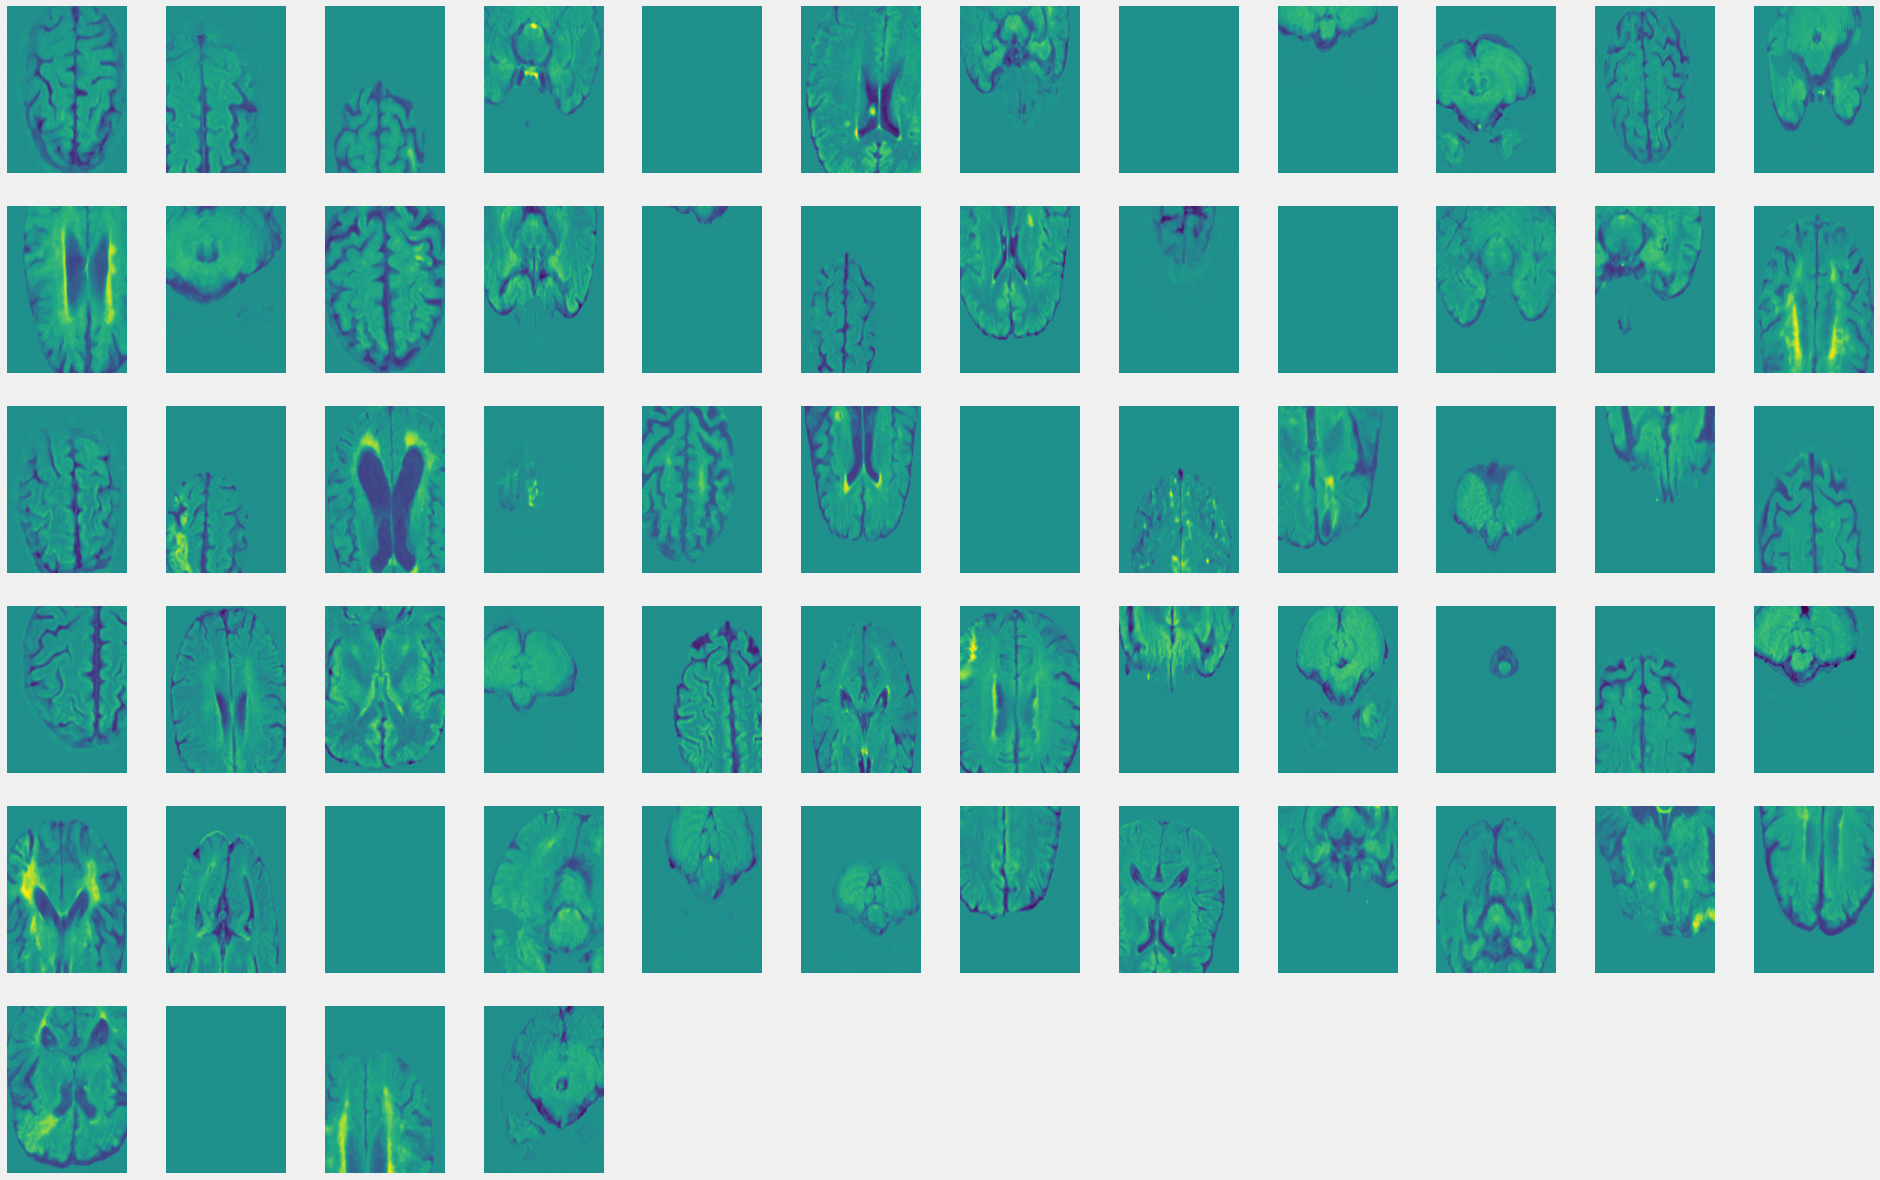

In [134]:
plt.figure(figsize=(30,20))
for i in range(64):
    plt.subplot(6, 12, i+1)
    plt.imshow(xs[0][i][0], vmin=-4, vmax=4)
    plt.axis('off')

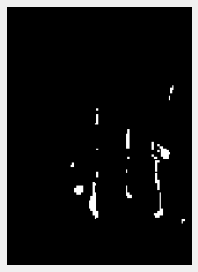

In [160]:
plt.imshow(ys[0][5], cmap='gray');
plt.axis('off');
save("label_img5")

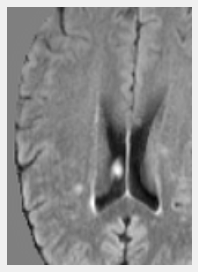

In [164]:
plt.imshow(xs[0][5][0], cmap='gray', vmin=-4, vmax=4);
plt.axis('off');
save("flair_img5")

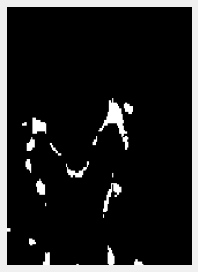

In [158]:
plt.imshow(ys[0][20], cmap='gray');
plt.axis('off');
save("label_img20")

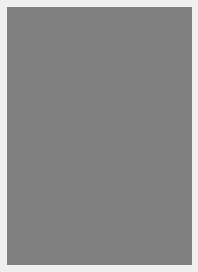

In [165]:
plt.imshow(xs[0][20][0], cmap='gray', vmin=-4, vmax=4);
plt.axis('off');
save("flair_img20")

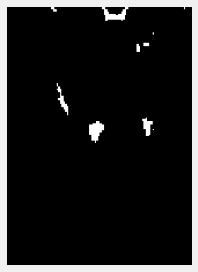

In [144]:
plt.imshow(ys[0][58], cmap='gray');
plt.axis('off');
save("label_img58")

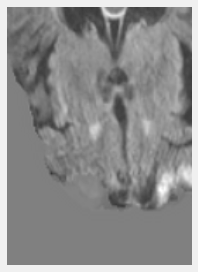

In [166]:
plt.imshow(xs[0][58][0], cmap='gray', vmin=-4, vmax=4);
plt.axis('off');
save("flair_img58")

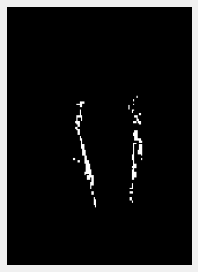

In [145]:
plt.imshow(ys[0][37], cmap='gray');
plt.axis('off');
save("label_img37")

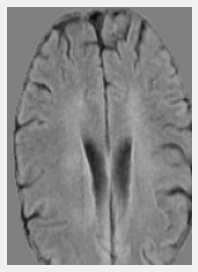

In [167]:
plt.imshow(xs[0][37][0], cmap='gray', vmin=-4, vmax=4);
plt.axis('off');
save("flair_img37")

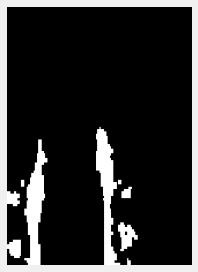

In [147]:
plt.imshow(ys[0][62], cmap='gray');
plt.axis('off');
save("label_img62")

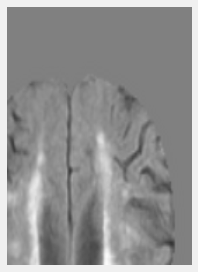

In [168]:
plt.imshow(xs[0][62][0], cmap='gray', vmin=-4, vmax=4);
plt.axis('off');
save("flair_img62")

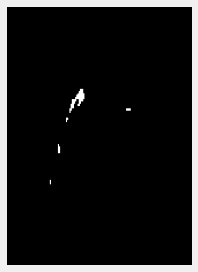

In [148]:
plt.imshow(ys[0][49], cmap='gray');
plt.axis('off');
save("label_img49")

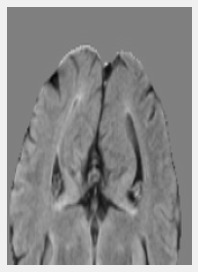

In [169]:
plt.imshow(xs[0][49][0], cmap='gray', vmin=-4, vmax=4);
plt.axis('off');
save("flair_img49")

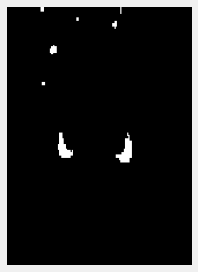

In [149]:
plt.imshow(ys[0][50], cmap='gray');
plt.axis('off');
save("label_img50")

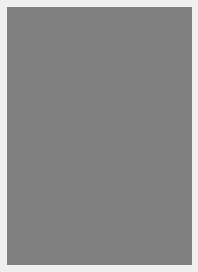

In [170]:
plt.imshow(xs[0][50][0], cmap='gray', vmin=-4, vmax=4);
plt.axis('off');
save("flair_img50")

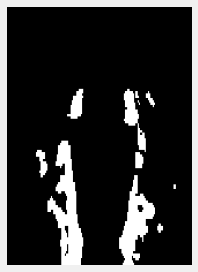

In [150]:
plt.imshow(ys[0][23], cmap='gray');
plt.axis('off');
save("label_img23")

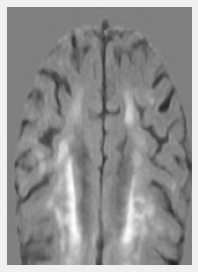

In [171]:
plt.imshow(xs[0][23][0], cmap='gray', vmin=-4, vmax=4);
plt.axis('off');
save("flair_img23")

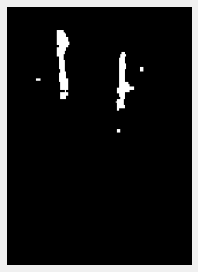

In [151]:
plt.imshow(ys[0][30], cmap='gray');
plt.axis('off');
save("label_img30")

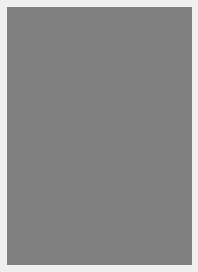

In [172]:
plt.imshow(xs[0][30][0], cmap='gray', vmin=-4, vmax=4);
plt.axis('off');
save("flair_img30")

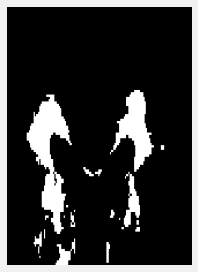

In [152]:
plt.imshow(ys[0][48], cmap='gray');
plt.axis('off');
save("label_img48")

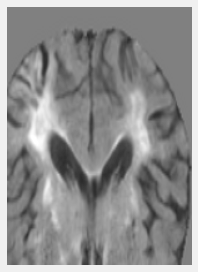

In [173]:
plt.imshow(xs[0][48][0], cmap='gray', vmin=-4, vmax=4);
plt.axis('off');
save("flair_img48")

In [135]:
accelerator="gpu"
devices=1
max_epochs=100
precision = 32

rootdir = "/disk/scratch/s2208943/results/final_models/"
ckpt_dir = "nana"
final_dir = rootdir + ckpt_dir
checkpoint_callback = ModelCheckpoint(final_dir, save_top_k=2, monitor="val_loss")
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=0.01, patience=15, verbose="False", mode="min", check_finite=True)
trainer = pl.Trainer(
    callbacks=[checkpoint_callback, early_stop_callback],
    accelerator=accelerator,
    devices=devices,
    max_epochs=max_epochs,
    precision=precision,
    default_root_dir=final_dir
)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [136]:
dice_factor = 20
    
def punet_loss(net, pred, target):
    #elbo = net.elbo(target)
    xent, kl = net.elbo(target)
    reg_loss = l2_regularisation(net.posterior) + l2_regularisation(net.prior) + l2_regularisation(net.fcomb.layers)

    # print("elbo: ", elbo)

    # print("xent: " , xent)
    # print("kl: ", kl)
    # print("reg: ", reg_loss * 1e-5)

    dice = dice_loss(pred, target)

    if pred.max() > 1000 or pred.min() < -1000:
        print(pred.max(), pred.min())
        raise ValueError("to high")

    # print("dice: ", dice)

    #loss = -elbo * 1e-3 + 1e-5 * reg_loss + dice * 30
    #loss = -elbo * 1e-3 + 1e-5 * reg_loss + dice
    #loss = -elbo * 1e-3 + reg_loss * 1e-5 + dice
    #loss = dice #* 300
    loss = -xent *2e-4 -kl +1e-5*reg_loss + dice * dice_factor
   # loss = dice * 50 - kl
    #loss = dice
    #loss = -kl +(1e-5*reg_loss) + dice * 50
    return loss

In [137]:
model_raw = ProbabilisticUnet(input_channels=3, num_classes=2, num_filters=[16, 32, 64, 128, 256], latent_dim=14*20, no_convs_fcomb=4, beta=10.0)
    
loss = punet_loss

optimizer_params={"lr":1e-4}
optimizer = torch.optim.Adam
lr_scheduler_params={"milestones":[50,80], "gamma":0.5}
lr_scheduler_constructor = torch.optim.lr_scheduler.MultiStepLR

model = PUNetLitModelWrapper(model_raw, loss, 
                            logging_metric=DiceLossMetric,
                            optimizer_params=optimizer_params,
                            lr_scheduler_params=lr_scheduler_params,
                            is_uq_model=False,
                            optimizer_constructor=optimizer,
                            lr_scheduler_constructor=lr_scheduler_constructor
                           )


In [138]:
def ndigit(n, x):
    s = str(x)
    ns = "0" * (n - len(s))
    return ns + s

In [139]:
ndigit(2, 1)

'01'

### Loading the dataset in 3D for analysis
now each sample from the 3D dataset we can treat as a batch, and is a single image sample. Note that each batch may not be the same size now.

In [140]:
# load datasets
# this step is quite slow, all the data is being loaded into memory
# BIG NOTE
# during evaluating the modle, we set is_3d false here to avoid doing the z cropping (which can cause nans)
# and instead we run the whole brain scan through and it gives us a good prediction over all. Nice.
datasets_domains_3d = [MRISegmentation3DDataset(root_dir, domain, transforms=get_transforms(is_3D=False)) for domain in domains]


# split into train, val test datasets
datasets_3d = [train_val_test_split(dataset, validation_proportion, test_proportion, seed) for dataset in datasets_domains_3d]

# concat the train val test datsets
train_dataset_3d = ConcatDataset([ds[0] for ds in datasets_3d])
val_dataset_3d = ConcatDataset([ds[1] for ds in datasets_3d])
test_dataset_3d = ConcatDataset([ds[2] for ds in datasets_3d])

### generating the samples procedure, only do this once

In [13]:
from tqdm import tqdm

In [14]:
xs3d = []
ys3d = []
for x, y in val_dataset_3d:
    xs3d.append(x)
    ys3d.append(y)

In [17]:
root = "/home/s2208943/ipdis/results/final_models/"
folder = "new_punet_multi01/"

In [18]:
ckpts = sorted([c for c in os.listdir(root+folder) if "epoch" in c])
c = ckpts[-1]

In [19]:
#checkpoint = torch.load(root + folder + c)

In [20]:
#checkpoint['state_dict'].keys()

In [21]:
model = PUNetLitModelWrapper.load_from_checkpoint(root + folder + c, model=model_raw, loss=loss, 
                                logging_metric=DiceLossMetric)
model = model.cuda()

In [22]:
def gen_samples(xs3dQ, ys3dQ):
    samples3d = [[] for i in range(len(ys3dQ))]
    for i in tqdm(range(len(ys3dQ)), position=0, leave=True, ncols=150):
        
        model.eval()
        model(xs3dQ[i].swapaxes(0,1).cuda(), ys3dQ[i].cuda().unsqueeze(1))

        with torch.no_grad():
            for j in range(20):
                out = model.model.sample().squeeze().cpu()
                samples3d[i].append(out)
            
    samples3d = [torch.stack(ss) for ss in samples3d]
    return samples3d

In [23]:
samples3d = gen_samples(xs3d, ys3d)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:44<00:00,  1.09it/s]


In [24]:
means3d = [torch.mean(samples3d[i], dim=0) for i in range(len(samples3d))]

In [25]:
samples3d[0].shape, means3d[0].shape

(torch.Size([20, 40, 2, 224, 160]), torch.Size([40, 2, 224, 160]))

In [26]:
len(samples3d)

49

In [27]:
len(samples3d), len(samples3d[0])

(49, 20)

### generating the 2D samples of the first batch only, for the pictures! (and compute computation time)

In [28]:
import timeit

In [29]:
samples2d_onebatch = []
start_time = timeit.default_timer()
with torch.no_grad():
    model(xs[0].cuda(), ys[0].cuda().unsqueeze(1))
    for j in range(20):
        model.eval()
        out = model.model.sample().squeeze().cpu()
        samples2d_onebatch.append(out)
        
elapsed = timeit.default_timer() - start_time

In [30]:
print("elapsed time (s): ", elapsed)

elapsed time (s):  1.6487020351924002


In [31]:
len(samples2d_onebatch)

20

### fixed compute section

In [32]:
model_name = "punet_multivariate"

In [33]:
os.mkdir("results/" + model_name)

### Generating uncertainty maps for a batch


In [34]:
def entropy_map_from_samples(samples):
    "samples is of shape samples, batch size, channels, image dims  [s, b, c *<dims>]"
    probs = torch.nn.functional.softmax(samples, dim=2)
    pic = torch.mean(probs, dim=0)
    ent_map = torch.sum(-pic * torch.log(pic+1e-30), dim=1)
    
    return ent_map

### Creating the entropy map for the 2D samples

In [35]:
samples2d = torch.stack(samples2d_onebatch, dim=0)

In [36]:
samples2d.shape

torch.Size([20, 64, 2, 224, 160])

In [37]:
ent2dbatch = entropy_map_from_samples(samples2d)

In [38]:
ent2dbatch.shape

torch.Size([64, 224, 160])

In [39]:
def save(fname):
    plt.tight_layout()
    plt.savefig("results/"+model_name + "/" + fname, bbox_inches = "tight")


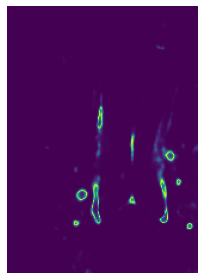

In [40]:
plt.imshow(ent2dbatch[5], vmin=0, vmax=0.7);
plt.axis('off');
save("img5")

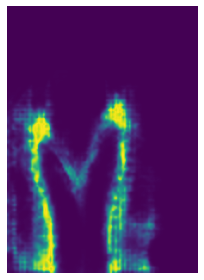

In [41]:
plt.imshow(ent2dbatch[20], vmin=0, vmax=0.7);
plt.axis('off');
save("img20")

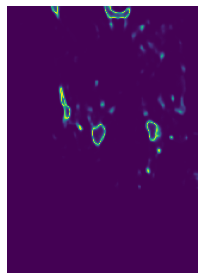

In [42]:
plt.imshow(ent2dbatch[58], vmin=0, vmax=0.7);
plt.axis('off');
save("img58")

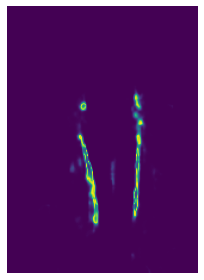

In [43]:
plt.imshow(ent2dbatch[37], vmin=0, vmax=0.7);
plt.axis('off');
save("img37")

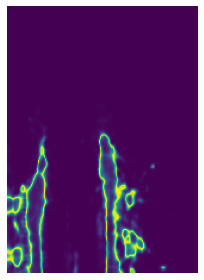

In [44]:
plt.imshow(ent2dbatch[62], vmin=0, vmax=0.7);
plt.axis('off');
save("img62")

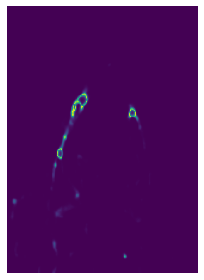

In [45]:
plt.imshow(ent2dbatch[49], vmin=0, vmax=0.7);
plt.axis('off');
save("img49")

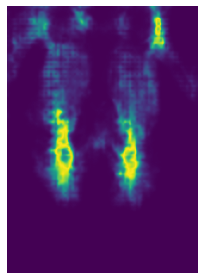

In [46]:
plt.imshow(ent2dbatch[50], vmin=0, vmax=0.7);
plt.axis('off');
save("img50")

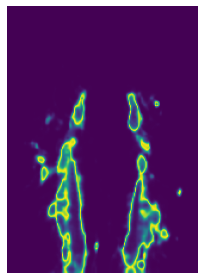

In [47]:
plt.imshow(ent2dbatch[23], vmin=0, vmax=0.7);
plt.axis('off');
save("img23")

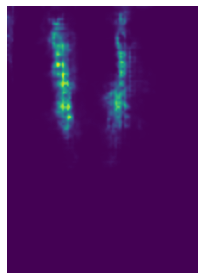

In [48]:
plt.imshow(ent2dbatch[30], vmin=0, vmax=0.7);
plt.axis('off');
save("img30")

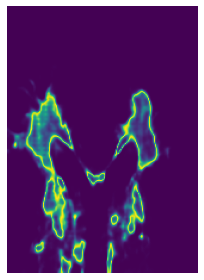

In [49]:
plt.imshow(ent2dbatch[48], vmin=0, vmax=0.7);
plt.axis('off');
save("img48")

In [50]:
# plt.figure(figsize=(30,20))
# ids = 5, 20, 58, 37, 62, 49, 50, 23, 30, 48
# count = 0
# for i in range(64):
#     if torch.sum(ys[0][i]) > 0:
#         plt.subplot(6, 12, count+1)
#         plt.imshow(ys[0][i], cmap='gray')
#         plt.title(i)
#         plt.axis('off')
#         plt.subplot(6, 12, count+2)
#         plt.imshow(ent2dbatch[i], vmin=0, vmax=0.7)
#         plt.title(i)
#         plt.axis('off')
#         count += 2

interesting images: 5, 20, 58, 37, 62, 49, 50, 23, 30, 48

### How do average dice and best dice improve with samples

In [51]:
len(samples3d), len(samples3d[0]), len(ys3d)

(49, 20, 49)

In [52]:
def dice(y_pred, y_true):
    y_pred = torch.nn.functional.softmax(y_pred, dim=1).argmax(dim=1)
    #print(y_pred.shape, y_true.shape)
    denominator = torch.sum(y_pred) + torch.sum(y_true)
    numerator = 2. * torch.sum(torch.logical_and(y_pred, y_true))
    return numerator / denominator

In [53]:
# compute the dice per sample, per individual
dices3d = []
for ind in tqdm(range(len(samples3d)), position=0, leave=True, ncols=150):
    sample_dices = []
    for s in range(len(samples3d[ind])):
        y_hat = samples3d[ind][s]
        y = ys3d[ind]
        sample_dices.append(dice(y_hat, y))
    dices3d.append(sample_dices)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [03:59<00:00,  4.89s/it]


In [54]:
tensor_alldice3d = torch.stack([torch.Tensor(ds) for ds in dices3d], dim=0).swapaxes(0,1)

In [55]:
tensor_alldice3d.shape

torch.Size([20, 49])

In [56]:
# compute the mean and best dice as the number of samples increases from 1 to 20:
samples_vs_dices_mean = []
samples_vs_dices_best = []
for i in range(20):
    selected_samples_dices = tensor_alldice3d[0:i+1]
    mean_dice = torch.mean(selected_samples_dices, dim=0)
    best_dice = torch.max(selected_samples_dices, dim=0)[0]
    
    samples_vs_dices_mean.append(mean_dice.mean())
    samples_vs_dices_best.append(best_dice.mean())

In [57]:
mean_dice.mean(),mean_dice.std(), best_dice.mean(), best_dice.std()

(tensor(0.6561), tensor(0.1410), tensor(0.6612), tensor(0.1394))

In [58]:
samples_vs_dices_mean[0].shape

torch.Size([])

In [59]:
plt.style.use('fivethirtyeight')

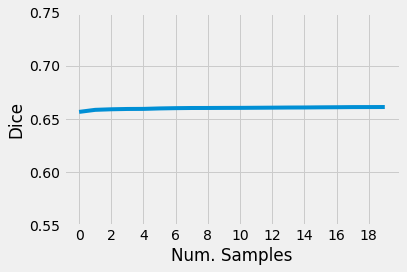

In [60]:
plt.plot(torch.arange(0, len(samples_vs_dices_mean), 1), samples_vs_dices_best)
plt.ylim(0.55, 0.75)
plt.xticks(torch.arange(0, 20, 2));
plt.xlabel("Num. Samples")
plt.ylabel("Dice");
save("samples_v_dice")

In [61]:
#print(torch.Tensor(samples_vs_dices_best))

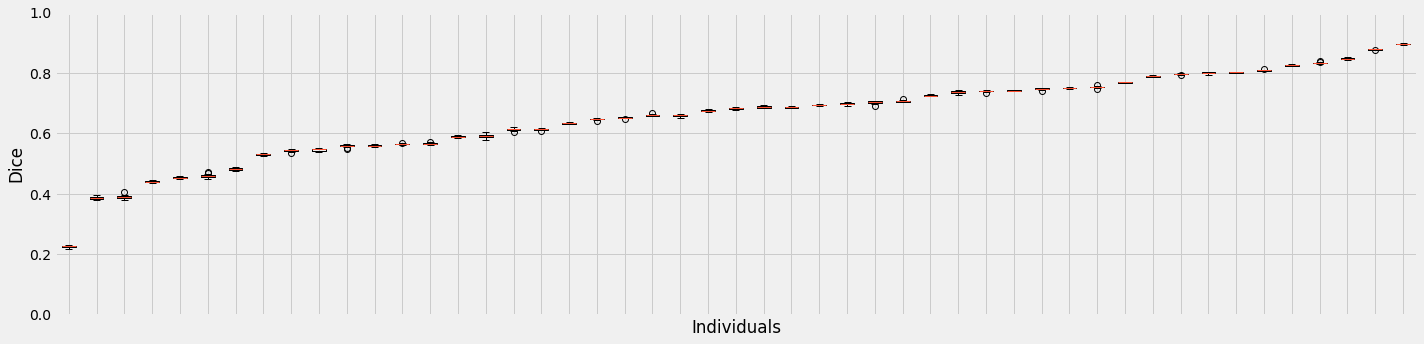

In [62]:
# sort in order of quality
order = torch.sort(torch.median(tensor_alldice3d, dim=0)[0])[1]
plt.figure(figsize=(20, 5))
plt.boxplot(tensor_alldice3d.T[order]);
plt.ylim(0, 1);
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.ylabel("Dice")
plt.xlabel("Individuals")
save("sample_diversity")

### Calibration

In [63]:
def place_in_bin(value):
    return torch.round(value, decimals=1)

In [64]:
def rolling_average(value, n, G):
    return value / n + ((n-1) / n) * G

def batch_rolling_average(values, n, G):
    """
    assumes all batches but the last batch are the same size
    """
    return values.sum() / (values.shape[0]*n) + ((n-1) / n) * G

In [65]:
len(samples3d)

49

In [66]:
# assess bin counts of p y = 1
bins = 10 + 1 # for the 0 bin
bin_batch_accuracies = [[] for b in range(bins)]
bin_batch_confidences = [[] for b in range(bins)]
bin_batch_sizes = [[] for b in range(bins)]
bin_counts = [0 for b in range(bins)]
for batch_idx in tqdm(range(len(ys3d)), ncols=150, position=0, leave=True): # skip the last batch with a different shape
    batch_t = ys3d[batch_idx]
    batch_samples = samples3d[batch_idx]
    
    if batch_t.shape[0] < 10:
        continue # skip last batch if it is very small.
    
    # get probabilities
    probs = torch.nn.functional.softmax(batch_samples, dim=2)
    p1s = probs[:,:,1]
    
    # split into bins
    bin_ids = place_in_bin(p1s)
    
    # compute counts
    for i in range(bins):
        is_in_bin = (bin_ids == (i / 10))
        # print(is_in_bin.shape)
        # print(batch_t.shape)
        
        # number of elements in each bin
        num_elem = torch.sum(is_in_bin).item()
        if num_elem == 0:
            print("zero")
        
        # number of predictions = to class 1
        c1_acc = batch_t.expand(p1s.shape)[is_in_bin].sum() / num_elem
        
        if torch.isnan(c1_acc):
            print("acc_nan")
        
        # average confidence of values in that bin
        c1_conf = p1s[is_in_bin].mean()
        
        if torch.isnan(c1_conf):
            print("conf_nan")
        
        bin_batch_accuracies[i].append(c1_acc)
        bin_batch_confidences[i].append(c1_conf)
        bin_batch_sizes[i].append(num_elem)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [02:19<00:00,  2.84s/it]


In [67]:
bin_sizes = [torch.Tensor(bbs).sum() for bbs in bin_batch_sizes]
bin_accuracies = [torch.Tensor([bin_batch_accuracies[i][j] * bin_batch_sizes[i][j] / bin_sizes[i] for j in range(len(bin_batch_accuracies[i]))]).sum().item() for i in range(len(bin_sizes))]
bin_confidences = [torch.Tensor([bin_batch_confidences[i][j] * bin_batch_sizes[i][j] / bin_sizes[i] for j in range(len(bin_batch_confidences[i]))]).sum().item() for i in range(len(bin_sizes))]


In [68]:
bin_accuracies

[0.000829890021122992,
 0.15928936004638672,
 0.2454880028963089,
 0.30992749333381653,
 0.3675060570240021,
 0.42127659916877747,
 0.4756893813610077,
 0.5389423370361328,
 0.6191703081130981,
 0.7555415034294128,
 0.9291374683380127]

In [69]:
bin_confidences

[0.0002061269333353266,
 0.08900332450866699,
 0.19552479684352875,
 0.29756441712379456,
 0.39869704842567444,
 0.49957019090652466,
 0.6005229949951172,
 0.7016836404800415,
 0.8039973974227905,
 0.9081624746322632,
 0.9807265400886536]

In [70]:
total_size = torch.sum(torch.Tensor(bin_sizes)[1:])
ece = torch.sum( (torch.Tensor(bin_sizes)[1:]/ total_size) * (torch.abs(torch.Tensor(bin_accuracies)[1:] - torch.Tensor(bin_confidences)[1:])))
print("EXPECTED CALIBRATION ERROR: note we skip the first bin due to its size", ece)

EXPECTED CALIBRATION ERROR: note we skip the first bin due to its size tensor(0.0837)


In [71]:
"""
looking at just the class one calibration is useful due to the extreme lack of class 1 in the image, this gives us a better idea of how the model is doing
and when optimizing calibration I should be optimizing this.
"""

'\nlooking at just the class one calibration is useful due to the extreme lack of class 1 in the image, this gives us a better idea of how the model is doing\nand when optimizing calibration I should be optimizing this.\n'

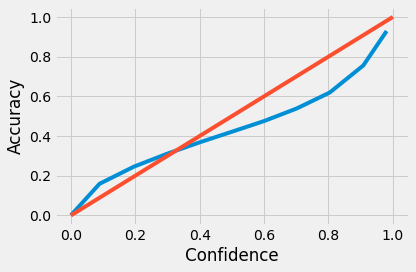

In [72]:
plt.plot(bin_confidences, bin_accuracies)
plt.plot([0,1],[0,1]);
plt.xlabel("Confidence")
plt.ylabel("Accuracy");
save("calibration")

In [73]:
#exd = batch_t.expand(p1s.shape)

In [74]:
# plt.bar([i for i in range(bins)], torch.Tensor(bin_sizes), align='center')
# plt.yscale("log")

### Compute the PavPU metrics cause I'm not convinced my previous code in original ssn notebook was incorrect.

In [75]:
# I am going to do it per patch, but take the average accuracy per patch (perhaps I should qc average dice as well, best dice, worst dice.
uncetainty_thresholds = torch.arange(0, 0.7, 0.01)
accuracy_threshold = 0.9
window = 8
stride = 8
n_acs = [[] for i in range(len(uncetainty_thresholds))]
n_aus = [[] for i in range(len(uncetainty_thresholds))]
n_ics = [[] for i in range(len(uncetainty_thresholds))]
n_ius = [[] for i in range(len(uncetainty_thresholds))]

for batch_idx in tqdm(range(len(ys3d)), ncols=150, position=0, leave=True): # skip the last batch with a different shape
    batch_t = ys3d[batch_idx]
    batch_samples = samples3d[batch_idx]
    ent = entropy_map_from_samples(batch_samples)
    
    # get probabilities
    probs = torch.nn.functional.softmax(batch_samples, dim=2)
    pred_classes = probs.argmax(dim=2)
    confidences = probs.max(dim=2)[0]
    
    # get average accuracy of each sample
    # or I could treat each patch of each sample as a separate thing but that is not what I am doing here.
    avg_accuracy = ((batch_t.expand(pred_classes.shape) == pred_classes) * 1.).mean(dim=0)
    
    # unroll predictions and targets and entropy
    t_unrolled = batch_t.unfold(-2, window, stride).unfold(-1, window, stride).reshape(-1, window, window)
    accuracy_unrolled = avg_accuracy.unfold(-2, window, stride).unfold(-1, window, stride).reshape(-1, window, window)
    ent_unrolled = ent.unfold(-2, window, stride).unfold(-1, window, stride).reshape(-1, window, window)
    
    accurate_patches = accuracy_unrolled > 0.9
    
    # for each uncertainty threshold, compute the 4 numbers
    for i, uncert_t in enumerate(uncetainty_thresholds):
        uncertain_patches = ent_unrolled > uncert_t
        
        n_acs[i].append(torch.sum(torch.logical_and(accurate_patches, ~uncertain_patches)))
        n_aus[i].append(torch.sum(torch.logical_and(accurate_patches, uncertain_patches)))
        n_ics[i].append(torch.sum(torch.logical_and(~accurate_patches, ~uncertain_patches)))
        n_ius[i].append(torch.sum(torch.logical_and(~accurate_patches, uncertain_patches)))
        

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [04:35<00:00,  5.61s/it]


In [76]:
n_acs_t = [torch.Tensor(n_acs[i]).sum() for i in range(len(uncetainty_thresholds))]
n_aus_t = [torch.Tensor(n_aus[i]).sum() for i in range(len(uncetainty_thresholds))]
n_ics_t = [torch.Tensor(n_ics[i]).sum() for i in range(len(uncetainty_thresholds))]
n_ius_t = [torch.Tensor(n_ius[i]).sum() for i in range(len(uncetainty_thresholds))]

In [77]:
p_acs = [n_acs_t[i] / (n_acs_t[i] + n_ics_t[i]) for i in range(len(uncetainty_thresholds))]
p_aus = [n_ius_t[i] / (n_ius_t[i] + n_ics_t[i]) for i in range(len(uncetainty_thresholds))]
pavpu = [(n_acs_t[i] + n_ius_t[i]) / (n_ius_t[i] + n_ics_t[i] + n_aus_t[i] + n_acs_t[i]) for i in range(len(uncetainty_thresholds))]

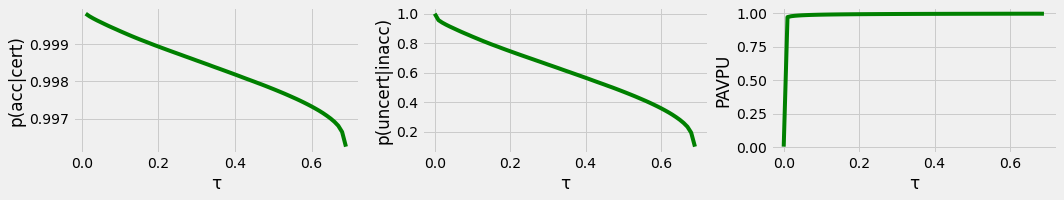

In [78]:
plt.figure(figsize=(15,3))
plt.subplot(1,3,1)
plt.plot(uncetainty_thresholds, p_acs, c='g')
plt.xlabel("τ")
plt.ylabel("p(acc|cert)")
plt.subplot(1,3,2)
plt.plot(uncetainty_thresholds, p_aus, c='g')
plt.ylabel("p(uncert|inacc)")
plt.xlabel("τ")
plt.subplot(1,3,3)
plt.plot(uncetainty_thresholds, pavpu, c='g')
plt.ylabel("PAVPU")
plt.xlabel("τ")
save("pavpu")


In [79]:
#uncetainty_thresholds

In [80]:
i=5
uncetainty_thresholds[i], p_acs[i], p_aus[i], pavpu[i]

(tensor(0.0500), tensor(0.9996), tensor(0.9010), tensor(0.9849))

In [81]:
#ent_thresh = uncetainty_thresholds[i]

In [82]:
ent_thresh = 0.05

### Quality Control in 3D - vcc corr-coeff

In [83]:
# generate entropy maps per individual
ind_ent_maps = [entropy_map_from_samples(samples3d[i]) for i in range(len(ys3d))]

In [84]:
def VVC(v):
    v = torch.nn.functional.softmax(v, dim=2)
    return torch.std(v) / torch.mean(v)

In [85]:
vvcs = [VVC(samples3d[i]) for i in range(len(ys3d))]

In [86]:
#vvcs_ent = [VVC(ind_ent_maps[i]) for i in range(len(ys3d))]

In [87]:
medians = torch.median(tensor_alldice3d, dim=0)[0]

In [88]:
print("correlation coefficient: ", torch.corrcoef(torch.stack([torch.Tensor(vvcs), medians]))[0][1])

correlation coefficient:  tensor(-0.5506)


In [89]:
#plt.scatter(vvcs, medians)

### TP FP TN FN distribution

In [90]:
all_tps = []
#all_tns = []
all_fps = []
all_fns = []

with torch.no_grad():
    for i in tqdm(range(len(ys3d)), position=0, leave=True, ncols=150):
        samples = samples3d[i]
        mean = means3d[i]
        ent = ind_ent_maps[i].view(-1)
        mean_class = mean.argmax(dim=1).view(-1)
        y = ys3d[i]
        x = xs3d[i].swapaxes(0,1)
        y_flat = y.view(-1)
        
        tp_loc = torch.where(torch.logical_and(y_flat == 1, mean_class == 1))[0]
        #tn_loc = torch.where(torch.logical_and(torch.logical_and(y_flat == 0, mean_class == 0), x[:,1].reshape(-1) == 1))[0]
        fp_loc = torch.where(torch.logical_and(y_flat == 0, mean_class == 1))[0]
        fn_loc = torch.where(torch.logical_and(torch.logical_and(y_flat == 1, mean_class == 0), x[:,1].reshape(-1) == 1))[0]
        # print(tp_loc.shape)
        # print(ent.view(-1).shape)
        
        all_tps.append(ent[tp_loc])
        #all_tns.append(ent[tn_loc])
        all_fps.append(ent[fp_loc])
        all_fns.append(ent[fn_loc])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:12<00:00,  3.98it/s]


In [91]:
tps = torch.cat(all_tps)
#tns = torch.cat(all_tns)
fps = torch.cat(all_fps)
fns = torch.cat(all_fns)

In [92]:
tps.shape, fps.shape, fns.shape

(torch.Size([505584]), torch.Size([146061]), torch.Size([179258]))

In [93]:
tps.mean(), fps.mean(), fns.mean()

(tensor(0.2384), tensor(0.4609), tensor(0.3278))

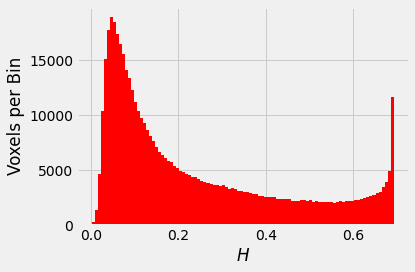

In [94]:
plt.hist(tps, bins=100, color='r');
plt.ylabel("Voxels per Bin")
#plt.ylim((0, 350000))
plt.xlabel("$H$")
save("tps")

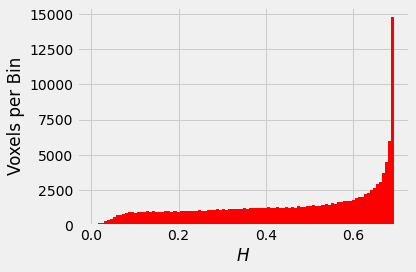

In [95]:
plt.hist(fps, bins=100, color='r');
plt.ylabel("Voxels per Bin")
#plt.ylim((0, 50000))
plt.xlabel("$H$")
save("fps")

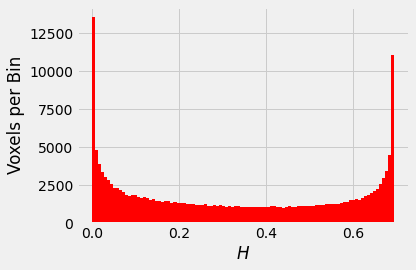

In [96]:
plt.hist(fns, bins=100, color='r');
plt.ylabel("Voxels per Bin")
#plt.ylim((0, 155000))
plt.xlabel("$H$")
save("fns")

In [97]:
import seaborn as sns

In [98]:
j = -1
ntps = len(tps)
nfns = len(fns)
nfps = len(fps)
data = {"label":["TP" for _ in range(ntps)][0:j] + ["FN" for _ in range(nfns)][0:j] + ["FP" for _ in range(nfps)][0:j], "ent": torch.cat([tps[0:j], fns[0:j], fps[0:j]]).numpy()}

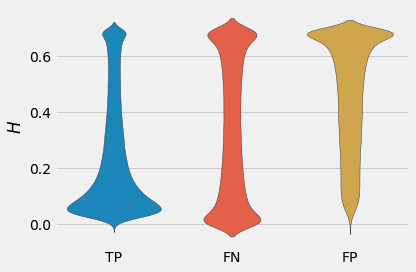

In [99]:
#plt.figure(figsize=(20, 5))
sns.violinplot(x="label", y="ent", data=data, linewidth=0.5, inner=None)
plt.ylabel("$H$")
save("types_violin")

### Missing lesions in 2D slices

In [100]:
from typing import Dict, Tuple

import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import numpy as np
import kornia as K

def create_random_labels_map(classes: int) -> Dict[int, Tuple[int, int, int]]:
    labels_map: Dict[int, Tuple[int, int, int]] = {}
    for i in classes:
        labels_map[i] = torch.randint(0, 255, (3, ))
    labels_map[0] = torch.zeros(3)
    return labels_map

def labels_to_image(img_labels: torch.Tensor, labels_map: Dict[int, Tuple[int, int, int]]) -> torch.Tensor:
    """Function that given an image with labels ids and their pixels intrensity mapping, creates a RGB
    representation for visualisation purposes."""
    assert len(img_labels.shape) == 2, img_labels.shape
    H, W = img_labels.shape
    out = torch.empty(3, H, W, dtype=torch.uint8)
    for label_id, label_val in labels_map.items():
        mask = (img_labels == label_id)
        for i in range(3):
            out[i].masked_fill_(mask, label_val[i])
    return out

def show_components(img, labels):
    color_ids = torch.unique(labels)
    labels_map = create_random_labels_map(color_ids)
    labels_img = labels_to_image(labels, labels_map)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,12))
    
    # Showing Original Image
    ax1.imshow(img)
    ax1.axis("off")
    ax1.set_title("Orginal Image")
    
    #Showing Image after Component Labeling
    ax2.imshow(labels_img.permute(1,2,0).squeeze().numpy())
    ax2.axis('off')
    ax2.set_title("Component Labeling")

In [101]:
conncomp_outs = []

for y in tqdm(ys3d, position=0, leave=True, ncols=150):
    labels_out = K.contrib.connected_components(y.unsqueeze(1).type(torch.float32), num_iterations=150)
    conncomp_outs.append(labels_out)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [01:28<00:00,  1.81s/it]


In [102]:
missing_lesion_size_ent = []
existing_lesion_size_ent = []
proportion_missing_lesion_covered_ent = []
missing_lesion_size_mean = []
for batch in tqdm(range(len(ys3d)), position=0, leave=True, ncols=150):
    for i in range(0, ys3d[batch].shape[0], 3):
        conncomps = conncomp_outs[batch][i]
        ent = ind_ent_maps[batch][i]
        uncert = (ent > ent_thresh).type(torch.long)
        mean = means3d[batch].argmax(dim=1)[i]
        
        ids = conncomps.unique()[1:]
        for idx in ids:
            cc = (conncomps == idx)
            size = torch.sum(cc)
            if torch.max(uncert * cc) > 0:
                existing_lesion_size_ent.append(size)
            else:
                missing_lesion_size_ent.append(size)
                
            if torch.max(mean * cc) > 0:
                proportion_missing_lesion_covered_ent.append(torch.sum(uncert * cc) / size)
                missing_lesion_size_mean.append(size)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [03:20<00:00,  4.10s/it]


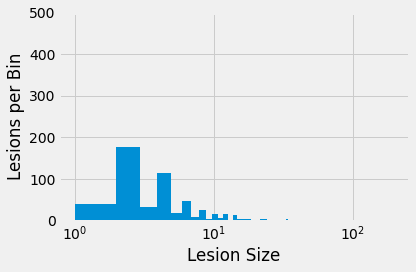

In [103]:
plt.hist(missing_lesion_size_ent, bins=200);
plt.xscale('log')
plt.ylim(0, 500)
plt.xlabel("Lesion Size")
plt.ylabel("Lesions per Bin")
save("missing_lesions")

In [104]:
print("means and stds of existing and missing lesions in 2D")
existing = torch.Tensor(existing_lesion_size_ent)
missing = torch.Tensor(missing_lesion_size_ent)
existing.mean(), existing.std(), missing.mean(), missing.std()

means and stds of existing and missing lesions in 2D


(tensor(86.2470), tensor(271.0905), tensor(7.0859), tensor(13.2015))

In [105]:
print("total number of lesions missing in 2D", len(missing_lesion_size_ent))

total number of lesions missing in 2D 582


In [106]:
print("mean proportion of missing lesion covered by uncertainty: ", torch.Tensor(proportion_missing_lesion_covered_ent).mean())

mean proportion of missing lesion covered by uncertainty:  tensor(0.9083)


### How do uncertainty maps differ depending on the WMH damage values?

In [107]:
true_wmh_damage = []
lhss = []
rhss = []

for i in range(len(ys3d)):
    x = xs3d[i]
    y = ys3d[i]

    min_intensity = torch.min(x[0])
    norm_max_intensity = torch.max(x[0][y == 1]) - min_intensity
    nawm_range = (norm_max_intensity*0.5 + min_intensity, norm_max_intensity*0.75 + min_intensity)
    wmh_voxels = x[0][y==1]
    nawm_voxels = x[0][torch.logical_and(torch.logical_and(torch.logical_and(y==0, x[1] == 1), x[0] > nawm_range[0]), x[0] < nawm_range[1])]

    I_wmh = torch.mean(wmh_voxels)
    I_nawm = torch.mean(nawm_voxels)

    wmh_volume = wmh_voxels.shape[0]
    nawm_volume = nawm_voxels.shape[0]

    lhs = ((I_wmh - I_nawm) / I_nawm)
    rhs = (wmh_volume / (wmh_volume + nawm_volume))
    damage = lhs * rhs

    true_wmh_damage.append(damage)
    lhss.append(lhs)
    rhss.append(rhs)

    print("I_wmh: ", I_wmh, "I_nawm: ", I_nawm, "wmh volume: ", wmh_volume, "normal volume: ", nawm_volume, lhs, rhs, damage)


I_wmh:  tensor(1.4590) I_nawm:  tensor(0.8673) wmh volume:  4869 normal volume:  237568 tensor(0.6823) 0.02008356810222862 tensor(0.0137)
I_wmh:  tensor(1.5194) I_nawm:  tensor(0.9066) wmh volume:  7084 normal volume:  183178 tensor(0.6759) 0.03723286836047135 tensor(0.0252)
I_wmh:  tensor(1.4373) I_nawm:  tensor(0.6962) wmh volume:  5084 normal volume:  391089 tensor(1.0646) 0.012832777599684986 tensor(0.0137)
I_wmh:  tensor(1.7887) I_nawm:  tensor(0.8932) wmh volume:  7700 normal volume:  142879 tensor(1.0026) 0.05113594857184601 tensor(0.0513)
I_wmh:  tensor(1.9693) I_nawm:  tensor(0.8594) wmh volume:  12105 normal volume:  175054 tensor(1.2913) 0.06467762704438472 tensor(0.0835)
I_wmh:  tensor(1.5166) I_nawm:  tensor(0.7567) wmh volume:  6332 normal volume:  392532 tensor(1.0042) 0.015875085242087528 tensor(0.0159)
I_wmh:  tensor(1.4261) I_nawm:  tensor(0.5993) wmh volume:  4289 normal volume:  541823 tensor(1.3797) 0.007853700339857026 tensor(0.0108)
I_wmh:  tensor(1.6832) I_nawm:

In [108]:
mean3ddice = tensor_alldice3d.mean(dim=0)

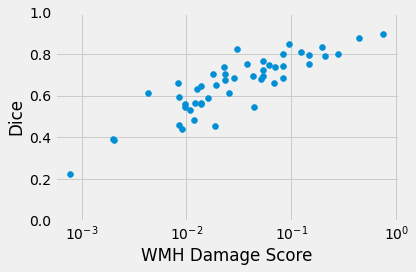

In [109]:
plt.scatter(true_wmh_damage, mean3ddice)
plt.xscale('log')
plt.ylim(0, 1)
plt.ylabel('Dice')
plt.xlabel('WMH Damage Score')
save("dice_v_damage")

In [110]:
ind_ent_sums = [torch.sum(e) for e in ind_ent_maps]

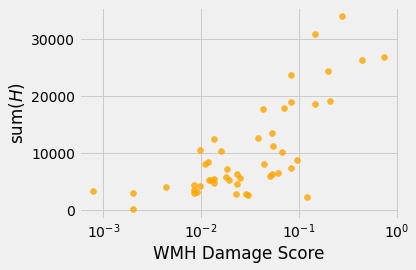

In [111]:
plt.scatter(true_wmh_damage, ind_ent_sums, alpha=0.8, c='orange')
plt.xscale('log')
plt.ylabel('sum($H$)')
plt.xlabel('WMH Damage Score')
save("ent_v_damage")

In [112]:
print("correlation coefficient: ", torch.corrcoef(torch.stack([torch.Tensor(ind_ent_sums), torch.log10(torch.Tensor(true_wmh_damage))]))[0][1])

correlation coefficient:  tensor(0.7407)


### Domain Adaption

In [113]:
domains_all = [wmh_dir + d for d in ["Singapore", "Utrecht", "GE3T"]
          ]

In [114]:
# load datasets
# this step is quite slow, all the data is being loaded into memory
datasets_domains_all = [MRISegmentation3DDataset(root_dir, domain, transforms=get_transforms(is_3D=False)) for domain in domains_all]


In [115]:
# assess bin counts of p y = 1
def ECE_domains(qys3d, qsamples3d):
    bins = 10 + 1 # for the 0 bin
    bin_batch_accuracies = [[] for b in range(bins)]
    bin_batch_confidences = [[] for b in range(bins)]
    bin_batch_sizes = [[] for b in range(bins)]
    bin_counts = [0 for b in range(bins)]
    for batch_idx in tqdm(range(0, len(qys3d)), ncols=150, position=0, leave=True): # skip the last batch with a different shape
        batch_t = qys3d[batch_idx]
        batch_samples = qsamples3d[batch_idx]

        if batch_t.shape[0] < 10:
            continue # skip last batch if it is very small.

        # get probabilities
        probs = torch.nn.functional.softmax(batch_samples, dim=2)
        p1s = probs[:,:,1]

        # split into bins
        bin_ids = place_in_bin(p1s)

        # compute counts
        for i in range(bins):
            is_in_bin = (bin_ids == (i / 10))
            # print(is_in_bin.shape)
            # print(batch_t.shape)

            # number of elements in each bin
            num_elem = torch.sum(is_in_bin).item()
            if num_elem == 0:
                print("zero")

            # number of predictions = to class 1
            c1_acc = batch_t.expand(p1s.shape)[is_in_bin].sum() / num_elem

            if torch.isnan(c1_acc):
                print("acc_nan")

            # average confidence of values in that bin
            c1_conf = p1s[is_in_bin].mean()

            if torch.isnan(c1_conf):
                print("conf_nan")

            bin_batch_accuracies[i].append(c1_acc)
            bin_batch_confidences[i].append(c1_conf)
            bin_batch_sizes[i].append(num_elem)

    bin_sizes = [torch.Tensor(bbs).sum() for bbs in bin_batch_sizes]
    bin_accuracies = [torch.Tensor([bin_batch_accuracies[i][j] * bin_batch_sizes[i][j] / bin_sizes[i] for j in range(len(bin_batch_accuracies[i]))]).sum().item() for i in range(len(bin_sizes))]
    bin_confidences = [torch.Tensor([bin_batch_confidences[i][j] * bin_batch_sizes[i][j] / bin_sizes[i] for j in range(len(bin_batch_confidences[i]))]).sum().item() for i in range(len(bin_sizes))]
    total_size = torch.sum(torch.Tensor(bin_sizes)[1:])
    ece = torch.sum( (torch.Tensor(bin_sizes)[1:]/ total_size) * (torch.abs(torch.Tensor(bin_accuracies)[1:] - torch.Tensor(bin_confidences)[1:])))
    print("EXPECTED CALIBRATION ERROR: note we skip the first bin due to its size", ece)

In [116]:
# compute the dice per sample, per individual
def dices_ind(qsamples, qys):
    qdices3d = []
    for ind in tqdm(range(0, len(qsamples)), position=0, leave=True, ncols=150):
        sample_dices = []
        for s in range(len(qsamples[ind])):
            y_hat = qsamples[ind][s]
            y = qys[ind]
            sample_dices.append(dice(y_hat, y))
        qdices3d.append(sample_dices)
        
    qtensor_alldice3d = torch.stack([torch.Tensor(ds) for ds in qdices3d], dim=0).swapaxes(0,1)
    qmean_dice = torch.mean(qtensor_alldice3d, dim=0)
    qbest_dice = torch.max(qtensor_alldice3d, dim=0)[0]
    
    return qmean_dice.mean(), qmean_dice.std(), qbest_dice.mean(), qbest_dice.std()




### domain 1

In [117]:
wxs3d = []
wys3d = []
for i in range(0, len(datasets_domains_all[0]), 3):
    x,y = datasets_domains_all[0][i]
    wxs3d.append(x)
    wys3d.append(y)

In [118]:
wsamples3d = gen_samples(wxs3d, wys3d)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.42it/s]


In [119]:
ECE_domains(wys3d, wsamples3d)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:17<00:00,  2.44s/it]

EXPECTED CALIBRATION ERROR: note we skip the first bin due to its size tensor(0.1007)


In [120]:
dices_ind(wsamples3d, wys3d)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:31<00:00,  4.57s/it]


(tensor(0.6495), tensor(0.1575), tensor(0.6562), tensor(0.1577))

### doamain 2

In [121]:
wxs3d = []
wys3d = []
for i in range(0, len(datasets_domains_all[1]), 3):
    x,y = datasets_domains_all[0][i]
    wxs3d.append(x)
    wys3d.append(y)

In [122]:
wsamples3d = gen_samples(wxs3d, wys3d)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.61it/s]


In [123]:
ECE_domains(wys3d, wsamples3d)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:16<00:00,  2.41s/it]

EXPECTED CALIBRATION ERROR: note we skip the first bin due to its size tensor(0.0953)


In [124]:
dices_ind(wsamples3d, wys3d)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:32<00:00,  4.58s/it]


(tensor(0.6474), tensor(0.1895), tensor(0.6560), tensor(0.1894))

### domain 3

In [125]:
wxs3d = []
wys3d = []
for i in range(0, len(datasets_domains_all[2]), 3):
    x,y = datasets_domains_all[0][i]
    wxs3d.append(x)
    wys3d.append(y)

In [126]:
wsamples3d = gen_samples(wxs3d, wys3d)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:04<00:00,  1.45it/s]


In [127]:
ECE_domains(wys3d, wsamples3d)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:16<00:00,  2.42s/it]

EXPECTED CALIBRATION ERROR: note we skip the first bin due to its size tensor(0.0884)


In [128]:
dices_ind(wsamples3d, wys3d)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:31<00:00,  4.56s/it]


(tensor(0.6465), tensor(0.2109), tensor(0.6550), tensor(0.2114))